<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch workflow

An example of a PyTorch end-to-end workflow

In [60]:
what_is_covered = {1: 'data (prepare and load)',
                   2: 'build model',
                   3: 'fit model to the data (training)',
                   4: 'make predictions and evaluate a model (inference)',
                   5: 'save and load a model',
                   6: 'put it all together'}

what_is_covered

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fit model to the data (training)',
 4: 'make predictions and evaluate a model (inference)',
 5: 'save and load a model',
 6: 'put it all together'}

In [61]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## 1. Data (prepare and load)

Data can be almost everything in Machine Learning

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine Learning is a game of two parts:
1. Get data into numerical representation
2. Build a model to learn patterns in that numerical representation

In [62]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [63]:
len(X), len(y)

(50, 50)

## Splitting data into train and test sets (one of the most important Machine Learning concepts)

In [64]:
# Create a train/test split
train_split = int(0.8 * len(X))

train_split

40

In [65]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How should the data be visualized?

This is where the data explorer's motto comes in:
'Visualize, visualize, visualize!'

In [66]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')
  # Plot testing data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')
  # Plot the predictions if they exist
  if predictions is not None:
    # Plot predictions in red
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14});

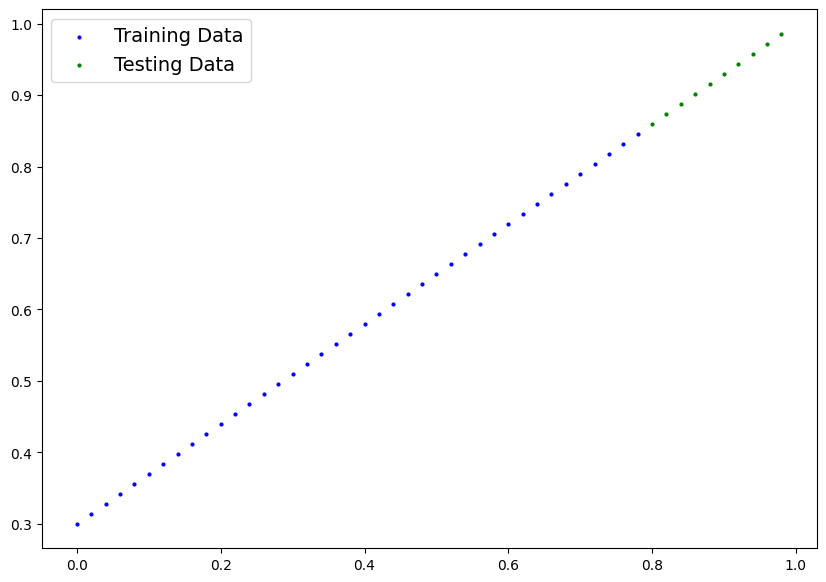

In [67]:
plot_predictions();

## 2. Build model

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values (the weight and bias used to create the data)

This is done through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [68]:
from torch import nn

# Create a linear regression model
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward method to define the computation in the method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (a neural network is considered a computational graph)
* torch.nn.Parameter - parameters the model should try and learn
* torch.nn.Module - the base class for all neural network modules, need to override the forward method when subclassed
* torch.optim - place of the optimizers needed in Gradient Descent
* forward method - defines what happens in the forward computation

### Checking the contents of the PyTorch model

In [69]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [70]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To test a model's predictive power, check how well it predicts `y_test` based on `X_test`

Passing data through a model, it is going to run it through the `forward()` method

In [71]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# One may do something similar with torch.no_grad(), however inference_mode is the prefered way
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [72]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

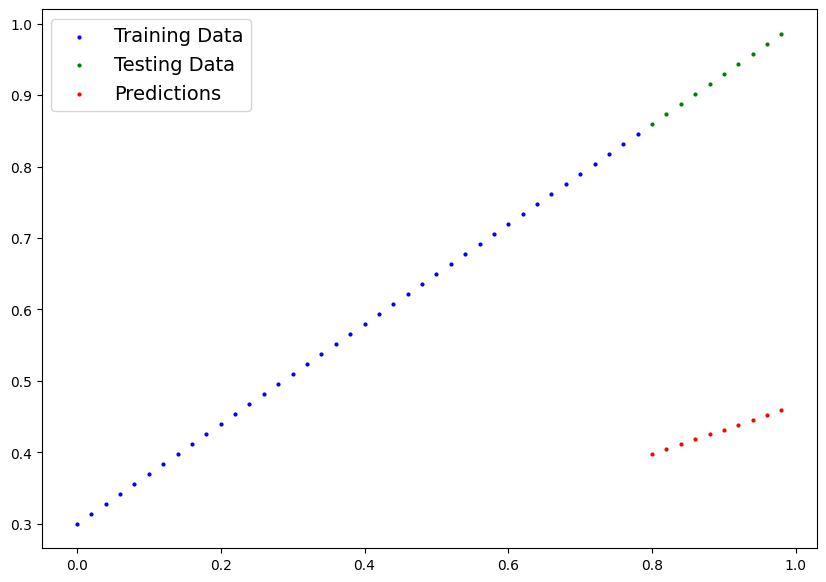

In [73]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for the model to move from *unknown* parameters (these may be random) to some *known* parameters.

In other words, from a poor representation to a better representation of the data.

One way to measure how wrong a model's predictions are is to use a loss function.

* **Note**: Loss function may also be called cost function or criterion in different areas.

Things needed to be trained:

* **Loss function**: A function to measure how wrong a model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (eg. weight & bias) to improve the loss function.
  * Inside the optimizer two parameters are often set:
    * `params` - the model parameters to optimize
    * `lr` - the learning rate, a hyperparameter that defines the way (big or small) the optimizer changes the parameters in each step (eg. small lr = small changes)

For PyTorch what is needed are:
* A training loop
* A testing loop

In [74]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [75]:
# Check out the models parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [76]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01) # Learning Rate - possibly the most important hyperparameter

## Building a training loop (and a testing loop) in PyTorch

A training loop needs:

0. Loop through the data and do...
1. Forward pass (this involves data moving through the model's `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss (**backpropagation**)
5. Optimizer step - use th optimizer to adjust the model's parameters to try to improve the loss (**gradient descent**)

In [77]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 100

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # Train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  model_0.eval()  # Turns off different settings in the model not needed for evaluation/testing

  with torch.inference_mode():  # Turns off gradient tracking and some things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}\n')
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495

OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428

OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688

OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703

OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106

OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024

OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135

OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

In [78]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [79]:
weight, bias

(0.7, 0.3)

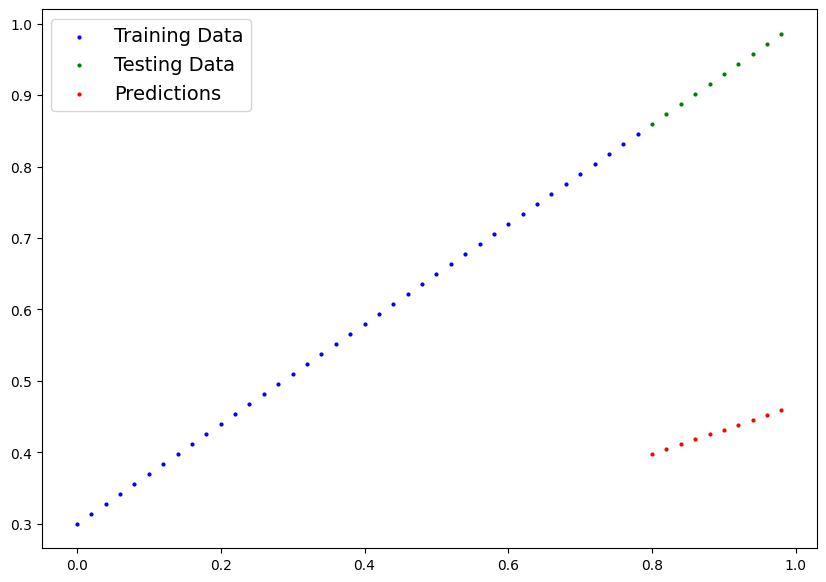

In [80]:
plot_predictions(predictions=y_preds);

In [81]:
# After executing the training loop for 10 epochs, the loss reduces and the preditions get closer to the desired values
with torch.inference_mode():
  y_preds_new = model_0(X_test)

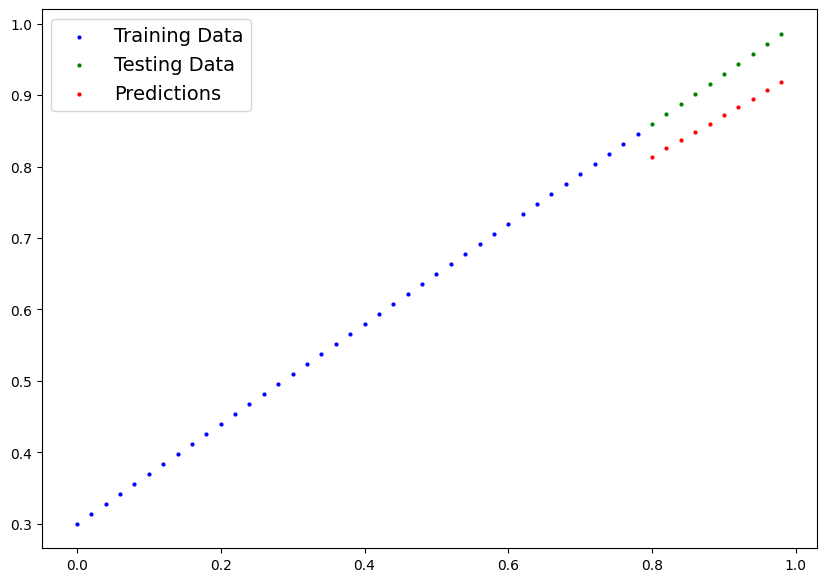

In [82]:
plot_predictions(predictions=y_preds_new);